# Kinetics III

We continue kinetic analysis.  Now that we have a basic understanding of the methods (least squares minimization, linearization, linear regression, etc.), we will work through noisy data (i.e., real data) obtained in a constant volume batch reactor.  We introduce a few tools for managing noisy data, and we consider the method of excess. We'll leverage several metrics that complement the sum of squares in helping us to understand goodness of fit; these include the coefficient of determination, $R^2$, and confidence intervals on parameter estimates.

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

**Analysis of "Real" Data Collected in a Constant Volume Batch Reactor.**

The following reaction is carried out in a well-mixed, constant volume batch reactor. The concentration of species A and B in the tank are initially 0.05M and 0.5M, respectively. The fluid inside of the reactor has constant density. 
	
$$A + B \longrightarrow C$$

You measure the concentration of species A in this reactor, monitoring how it changes with time.  The data you collect are given in the table below. 

| **time (min)** | **C$_A$ $\times 10^{2}$ (mol/L)** |
|:--------------:|:---------------------------------:|
|0               | 4.81                              |
|25              | 4.52                              |
|50              | 3.86                              |
|75              | 3.30                              |
|100             | 3.21                              |
|125             | 2.73                              |
|150             | 2.53                              |
|175             | 2.43                              |
|200             | 2.31                              |
|225             | 2.01                              |
|250             | 1.96                              |
|275             | 1.88                              |
|300             | 1.70                              |

Assuming the rate law is described by power law kinetics,

$$r = kC_A^{\alpha}C_B^{\beta}$$ 

where $\alpha$ is an integer and $\beta = 1$, determine the reaction order in A and the rate constant for this reaction.

### Solution to Example Problem 01

Before we start, it's important to point out something about regression and parameter estimation.  Here, we are looking for the order with respect to species A.  If we're trying to extract that order from data, it is easiest if we've performed an experiment where we are only varying the concentration of species A and watching how the system responds.  In a batch reactor, this is tricky because the concentration of species A and species B will both generally change as a function of time since both species are reactants.

The way we usually handle this is by performing the experiment in such a way that the only the concentration of interest varies (in this case, species A) while the other remains fixed.  A common way to do this is using the ***method of excess***. This  entails having one reactant present in a large excess so that its concentration does not significantly change over the course of the experiment.  Here, that is done with species B. Its initial concentration is 0.5M, whereas the initial concentration of A is 0.05M.  Clearly, A is the limiting reactant, and if we convert 100% of A, we would only decrease the concentration of species B by 10% to 0.45M.  This is typical of the method of excess. The change in concentration of species B over the course of the experiment is insignificant compared to the change in concentration of species A.  This allows us to extract the dependence on species A from our data.

In this case, we start with the following general rate expression:

$$r = k{C_A}^\alpha{C_B}^\beta$$

We know that $\beta$ = 1, so:

$$r = k{C_A}^\alpha{C_B}$$

Since in this experiment $C_B \approx C_{B0}$:

$$r = k{C_A}^\alpha{C_{B0}}$$

Since $C_{B0}$ is constant, we lump it it with the rate constant to get:

$$r = k^\prime{C_A}^\alpha$$

i.e., a rate expression that only depends on the concentration of A.  We just have to recall that the rate constate we estimate from this model, $k^\prime$ is actually defined as:

$$k^\prime = kC_{B0}$$

So if we want to get the true rate constant, $k$, we have to account for that dependence in the lumped constant in our final analysis.

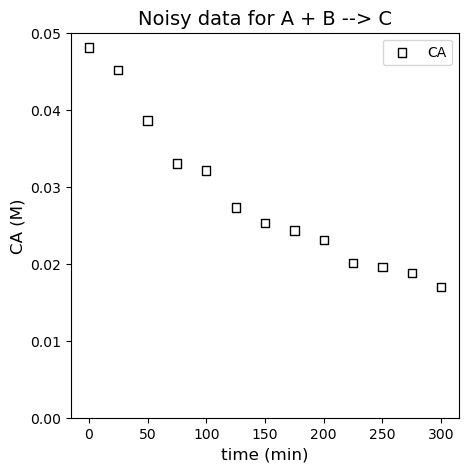

In [175]:
tdata = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
CAdata =np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                
#Concentrations in moles per liter

plt.figure(figsize = (5, 5))
plt.title('Noisy data for A + B --> C', fontsize = 14)
plt.scatter(tdata, CAdata, marker = 's', color = 'none', edgecolor = 'black', label = 'CA')
plt.ylim(0, 0.05)
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.legend()
plt.show()

Now we attempt to extract the rate constant, k, and reaction order in A, $\alpha$, from our experimental data. We are working with a power law model based on a lumped rate constant:

$$r = k^\prime{C_A}^\alpha$$

For a constant volume batch reactor, the balance on species A is therefore:

$$\frac{dC_A}{dt} = -k^\prime{C_A}^\alpha$$

We have options as usual.  Let's start with a differential analysis and then go to an integral analysis.

### Differential Analysis

The beauty of the differential analysis is that I can use it to estimate the reaction order when I really don't know one.  We know that it can introduce some imprecision because of limitations in finite difference approximations, but it is a useful way to start an analysis.  So let's go ahead and approximate the derivative in the above material balance using a forward difference method.

$$\frac{dC_A}{dt}\bigg|_{C_{A_n}} \approx \frac{C_{A_{n+1}} - C_{A_{n}}}{t_{n+1} - t_n}$$

With that, we would have a set of reaction rates at a corresponding set of CA values, and so we can consider how rate scales with concentration:

$$r = k{C_A}^\alpha$$

Which can be linearized using logarithms:

$$\ln(r) = \ln(k) + \alpha \ln(C_A)$$

In [176]:
ΔCA = np.diff(CAdata)
Δt  = np.diff(tdata)
r   = -1*ΔCA/Δt
print(len(CAdata))
print(len(r))

13
12


Recall that we have to use two data points to estimate a derivative, so our set of 13 measurments gives us 12 estimated derivatives using a forward difference method only. Now let's plot those rates against the corresponding concentrations on logarithmic axes to get a sense of the reaction order...

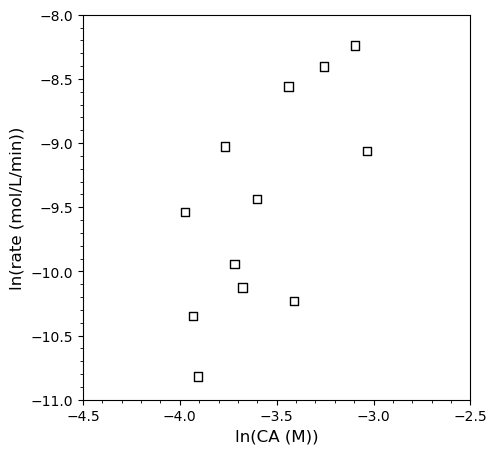

In [177]:
ydata = np.log(r)
xdata = np.log(CAdata[:-1])

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 's', color = 'none', edgecolor = 'black', label = 'CA')
plt.xlabel('ln(CA (M))', fontsize = 12)
plt.ylabel('ln(rate (mol/L/min))', fontsize = 12)
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-11, -8)
plt.show()

Yikes!  Let's see what linear regression gets us in terms of the reaction order and rate constant...

In [178]:
ydata = np.log(r)
xdata = np.log(CAdata[:-1])

X     = np.vander(xdata, 2) #This creates the vandermonde matrix, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) #solve for the coefficients by linear regression
m     = A[0]                  #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
α     = m                     #slope is reaction order
k     = np.exp(b)             #intercept is ln(k)

print(f'm = {m:0.2f}, b = {b:0.3f}, α = {α:0.2f}, k = {k:0.3f}')

m = 1.75, b = -3.220, α = 1.75, k = 0.040


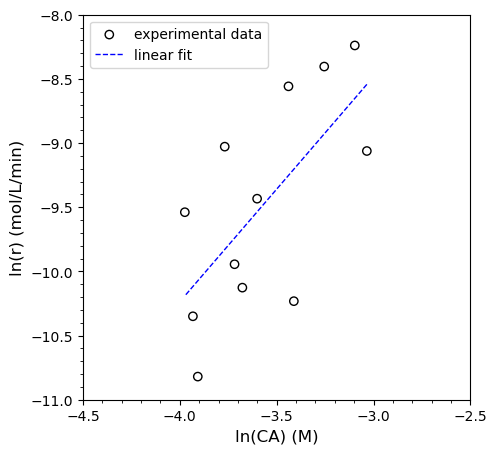

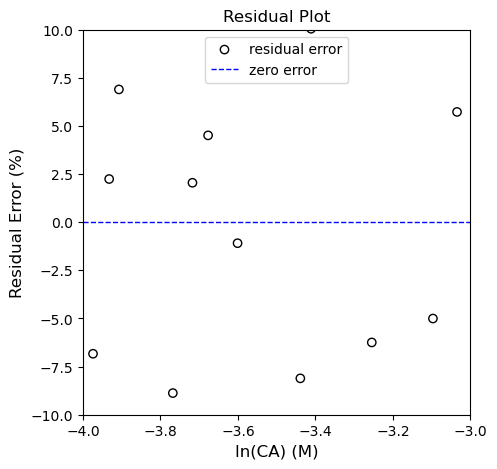

In [179]:
Ypred = X@A #this is the same as applying y = mx + b to every x in xdata

plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('ln(r) (mol/L/min)', fontsize = 12)
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-11, -8)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.xlim(-4.0, -3.0)
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

Clearly, that is a *rough* fit.  It suggests that my reaction order is 1.75 and that the rate constant is 0.04...but the data is all over the place. Let's add a bit more quantitative information information to this.  One thing that might be useful to us is knowing the residual sum of squares for this fit.  We have already seen how to calculate residual sum of squares in R10:

$$SSE = \sum_i \left(y_i - \hat{y}_i\right)^2$$

If we have already created the X, Y, and A arrays, then we can also calculate this with matrix multiplication:

$$SSE = (Y - XA)^T\cdot(Y - XA)$$

In [125]:
SSE1   = np.sum((ydata - Ypred)**2)
SSE2   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
print(f'α = {α:0.2f}, k = {k:0.3f}, Minimum SSE = {SSE2:0.2f}')

α = 1.75, k = 0.040, Minimum SSE = 4.19


One issue with the Residual Sum of Squares as presented here is that it is an "extensive" quantity of sorts: it will generally get larger as a) we make more measurements and b) we measure larger quantities.  So the absolute value of SSE is hard to interpret.  Some complementary metrics include the Mean Square Error (MSE), which captures the average error in an individual measurement:

$$MSE = \frac{1}{N}\sum_i(y_i - \hat{y}_i)^2$$

The MSE still will depend on the size of measurements that we are making, but it at least is normalized to an individual measurement. If we take the square root of the MSE, then we have the root mean square error, which gives us an estimate of the average absolute error in each measurement; it is also dependent on the size of the measurement that we are making, but it is informative as to goodness of fit as it is relatively easy to relate it to the magnitude of the measurements.

$$RMSE = \sqrt{\frac{1}{N}\sum_i(y_i - \hat{y}_i)^2}$$

Another thing of interest would be the coefficient of determination ($R^2$), which is intensive in that it conveys the same information (goodness of fit) no matter how many measurements we take or how large (or small) those measurements are.  Most of us are used to getting an $R^2$ directly alongside a trendline in Excel; they are straightforward to calculate. The general formula for the coefficient of determination is:

$$R^2 = 1 - \frac{\textrm{SSE}}{\textrm{SST}}$$

We calculate the residual sum of squares (SSE) using the standard formula:

$$SSE = \sum_i \left(y_i - \hat{y}_i\right)^2$$

The total sum of squares (SST) is a related metric that evaluates the amount of error between the measured values and the mean of the measured values:

$$SST = \sum_i \left(y_i - \bar{y}\right)^2$$


In the expressions above, $\hat{y}_i$ is the model prediction for the observable $y$ at condition $t_i$.  $\bar{y}$ is the mean of all measured values for the observable $y$.

Now that we have these definitions, let's go ahead and add the MSE and Coefficient of Determination to our output.

In [126]:
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    print(f'{label:4s} = {value:5.2f}')

m    =  1.75
b    = -3.22
SSE  =  4.19
SST  =  7.68
MSE  =  0.35
RMSE =  0.59
R2   =  0.45
α    =  1.75
k    =  0.04


There is one more useful piece of information we can get out of the linear regression routine -- we can use it to estimate the confidence intervals on the parameters that we have estimated ($\alpha$, and k).  Confidence intervals give us a sense of how much we trust the parameters that we have extracted from the data. You may recall the calculation of confidence intervals from your statistics course.  The first step is to caculate the standard error in the slope and intercept of our regression -- this requires us to estimate the covariance matrix. We can do this as follows:

First, we estimate the variance, $\sigma^2$ with the following:

$$\sigma^2 \approx s^2$$

and:

$$s^2 = \frac{SSE}{n_m - n_p}$$

Where $n_m$ is the number of measurements and $n_p$ is the number of regressed parameters.  This is also known as the "degrees of freedom" in our regression.

$$s^2 = \frac{SSE}{DOF}$$

Where: 

$$\text{DOF} = n_d - n_p$$

With that, we can estimate the covariance matrix from the measured data:

$$COV = s^2(X^TX)^{-1}$$

The standard error in our regressed parameters is given by the diagonal elements in the following matrix:

$$se = \sqrt{COV}$$

Noting that this may throw a warning if off-diagonal elements of the covariance matrix are negative.

From that, we get the standard error in the slope from `se[0,0]` and the standard error in the intercept from `se[1,1]`, i.e., the diagonal elements.

If you want to calculate confidence intervals, they are given by:

$$CI = t(q, DOF)\times SE$$

Where $t$ is the relvant value from a $t$ distribution assesed at a given level of confidence, $q$ and a given degrees of freedom $\text{DOF}$.  Here, we use a two tailed t distribution, which is appropriate when our uncertainty is positive or negative about the estimated value. We are intersted in 95% confidence intervals, so q will be 0.975 (we would use 0.95 only for a one tailed t distribution).

In [127]:
DOF    = len(ydata) - len(A)     #Degrees of freedom = number of measurements - number of regressed parameters
s2     = SSE/DOF                 #Estimate of variance, s2 ~ σ2  
COV    = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
SEm    = np.sqrt(COV[0, 0])      #Standard error in slope
SEb    = np.sqrt(COV[1, 1])      #Standard error in y-intercept
tval   = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm    = SEm*tval                #95% confidence interval on slope
CIb    = SEb*tval                #95% confidence interval on y-intercept
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIb:0.2f}')
    elif label == 'α':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2f} (but really is between {np.exp(b-CIb):0.2e} and {np.exp(b+CIb):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')

m    = 1.75 +/- 1.35
b    = -3.22 +/- 4.85
SSE  = 4.19
SST  = 7.68
MSE  = 0.35
RMSE = 0.59
R2   = 0.45
α    = 1.75 +/- 1.35
k    = 0.04 (but really is between 3.12e-04 and 5.11e+00)


m    = 1.75 +/- 1.35
b    = -3.22 +/- 4.85
SSE  = 4.19
SST  = 7.68
MSE  = 0.35
RMSE = 0.59
R2   = 0.45
α    = 1.75 +/- 1.35
k    = 0.04 (but really is between 3.12e-04 and 5.11e+00)


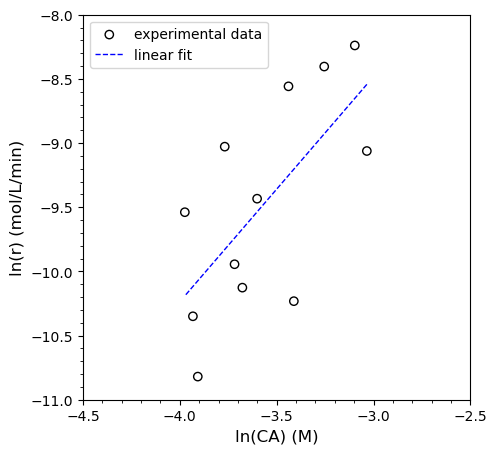

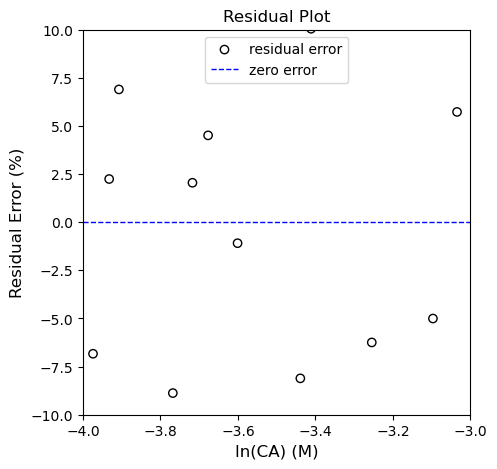

In [128]:
# Create matrices of x and y data
ydata = np.log(r)
xdata = np.log(CAdata[:-1])
X     = np.vander(xdata, 2) 
Y     = ydata 

# Perform linear regression 
A      = np.linalg.solve(X.T@X, X.T@Y) 

#Calculate statistics and model predictions
Ypred  = X@A
Ybar   = np.mean(ydata)
Ndata  = len(ydata)
SSE    = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST    = np.sum((Y - Ybar)**2) #Total sum of squares
MSE    = SSE/Ndata             #Mean Square Error
RMSE   = np.sqrt(MSE)          #Root Mean Square Error
R2     = 1 - SSE/SST           #R^2
DOF    = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2     = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV    = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m      = A[0]                  #slope of best fit line
b      = A[1]                  #y-intercept of best fit line
SEm    = np.sqrt(COV[0, 0])    #Standard error in slope
SEb    = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval   = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm    = SEm*tval              #95% confidence interval on slope
CIb    = SEb*tval              #95% confidence interval on y-intercept
α      = m
k      = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIb:0.2f}')
    elif label == 'α':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2f} (but really is between {np.exp(b-CIb):0.2e} and {np.exp(b+CIb):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')

# Overlay line of best fit with experimental data
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('ln(r) (mol/L/min)', fontsize = 12)
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-11, -8)
plt.legend()
plt.show()

#Create residual plot
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.xlim(-4.0, -3.0)
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

This is terrible!!!

What's going on here?  As we saw in L28, taking finite differences introduces imprecision even in perfect data.  Here, we have real (well, simulated real) data, where there is actual uncertainty and noise in the measurements. Sometimes our measurements are higher or lower than the "true" value at that time, and this compounds the uncertainty in the approximation that derivatives are constant when we use finite difference approximations.

Still, a differential analysis can be very useful...we can do a little better if we smooth the data before we estimate the derivative of that data.  One way that we can do that by fitting a polynomial to the data set.  We have to recognize that this polynomial fit is meaningless in a physical sense, it is just a way for us to develop a continuous, well-behaved function that empirically captures how concentration decreases with time.  Once we have that, we can take the true derivative of the polynomial (not a finite difference of data), and we can use that to estimate rate of reaction and thus reaction orders.  First, we fit the polynomial.  I'll use polyfit here because it makes it easy to adjust the order of the fit and display the results.  Note that this below is mimicking what you'd get by "increasing polynomial order" in an Excel trendline.

I find a third order polynomial does a good job of smoothing out the trend without fitting the noise, so we'll use that to provide a polynomial approximation of how concentration changes with time.

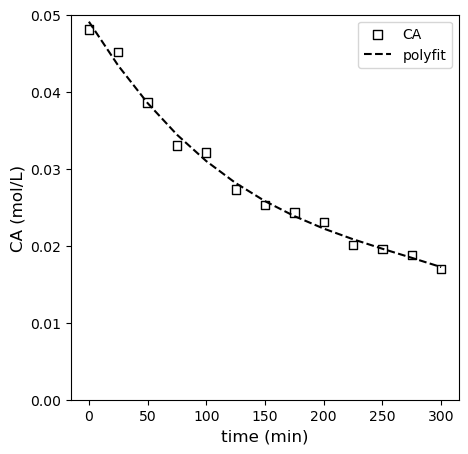

In [129]:
tdata = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
CAdata =np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                
#Concentrations in moles per liter

A      = np.polyfit(tdata, CAdata, 3)
CApoly = np.polyval(A, tdata)

plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, marker = 's', color = 'none', edgecolor = 'black', label = 'CA')
plt.plot(tdata, CApoly, color = 'black', linestyle = 'dashed', label = 'polyfit')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.ylim(0, 0.05)
plt.legend()
plt.show()

Numpy has some nice tools that allow us to take the derivative of a polynomial once we've generated it:

In [130]:
print(A)
print(f'[{3*A[0]:15.8E} {2*A[1]:15.8E} {1*A[2]:15.8E} {0*A[3]:15.8E}')#, ' ', 2*A[1], ' ', 1*A[2], 0*A[3])
print(np.polyder(A, m = 1))
derivatives    = np.polyder(A, m = 1)
rate_estimates = -1*np.polyval(derivatives, tdata)

[-9.30536131e-10  7.46493506e-07 -2.46443390e-04  4.90969780e-02]
[-2.79160839E-09  1.49298701E-06 -2.46443390E-04  0.00000000E+00
[-2.79160839e-09  1.49298701e-06 -2.46443390e-04]


Now that we have estimated the rates by taking a derivative of the polynomial approximation, let's try our linearization and regression again.

m    = 1.75 +/- 0.20
b    = -2.99 +/- 0.72
SSE  = 0.12
SST  = 4.30
MSE  = 0.01
RMSE = 0.10
R2   = 0.97
α    = 1.75 +/- 0.20
k    = 0.05 (but really is between 2.45e-02 and 1.03e-01)


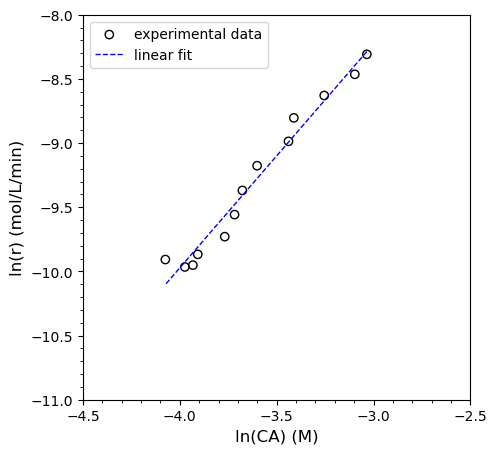

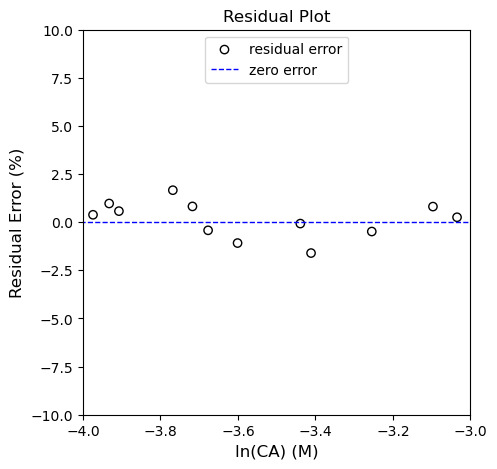

In [131]:
# Create matrices for linear regression of slope and intercept
ydata  = np.log(rate_estimates)
xdata  = np.log(CAdata)

# Perform linear regression
X      = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y      = ydata    
A      = np.linalg.solve(X.T@X, X.T@Y) 

#Calculate statistics and model predictions
Ypred  = X@A
Ybar   = np.mean(ydata)
Ndata  = len(ydata)
SSE    = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST    = np.sum((Y - Ybar)**2) #Total sum of squares
MSE    = SSE/Ndata             #Mean Square Error
RMSE   = np.sqrt(MSE)          #Root Mean Square Error
R2     = 1 - SSE/SST           #R^2
DOF    = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2     = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV    = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m      = A[0]                  #slope of best fit line
b      = A[1]                  #y-intercept of best fit line
SEm    = np.sqrt(COV[0, 0])    #Standard error in slope
SEb    = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval   = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm    = SEm*tval              #95% confidence interval on slope
CIb    = SEb*tval              #95% confidence interval on y-intercept
α      = m
k      = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIb:0.2f}')
    elif label == 'α':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2f} (but really is between {np.exp(b-CIb):0.2e} and {np.exp(b+CIb):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')

# Overlay line of best fit with experimental data
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('ln(r) (mol/L/min)', fontsize = 12)
plt.xlim(-4.5, -2.5)
plt.xticks(np.arange(-4.5, -2.49, 0.5))
plt.minorticks_on()
plt.ylim(-11, -8)
plt.legend()
plt.show()

#Create residual plot
plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln(CA) (M)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.xlim(-4.0, -3.0)
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

OK, so, the take home: the estimates of our order and rate constant didn't change much, but their precision did improve, which greatly increases my confidence. It is easier to accept the trend we see here because the fit is so much better.  Based on that and the confidence intervals, we find that the reaction order estimate is:

$$\alpha = 1.8 \pm 0.2$$

If we're restricting to integer orders, I'm going to guess these are probably second order kinetics, but let's work through an integral analysis and see if that bears out.

Based on this approach, the rate constant is obtained from the y-intercept, and we get a value of:

$k^\prime = 0.05$ 

But the confidence intervals are such that it probably is somewhere between 0.02 and 0.1 L/mol/min.

### Integral Analysis with nonlinear Regression

We'll start with the balance

$$\frac{dC_A}{dt} = -k^\prime{C_A}^\alpha$$

And we'll guess integer orders for $\alpha$ and see what shakes out.  I'm going to try $\alpha$ = 1, 2, and 3 in this example.

#### First Order Solution

For a first order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k^\prime C_A$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{C_A}dC_A = \int_0^t-k^\prime dt$$

Which gives:

$$C_A = C_{A0}\exp\left(-k^\prime t\right)$$

#### Second Order Solution

For a second order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k^\prime {C_A}^2$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^2}dC_A = \int_0^t-k^\prime dt$$

Which gives:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + k^\prime t$$

We can rearrange to get:

$$C_A = \left(\frac{1}{C_{A0}} + k^\prime t\right)^{-1}$$

#### Third Order Solution

For a third order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k^\prime {C_A}^3$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^3}dC_A = \int_0^t-k^\prime dt$$

Which gives:

$$\frac{1}{{C_A}^2} = \frac{1}{{C_{A0}}^2} + 2k^\prime t$$

We can rearrange to get:

$$C_A = \left(\frac{1}{{C_{A0}}^2} + 2k^\prime t\right)^{-\frac{1}{2}}$$

#### Summary of integrated models

To summarize, we have 3 models to compare to our data:

**First Order**: $C_A = C_{A0}\exp\left(-k^\prime t\right)$

**Second Order**: $\frac{1}{C_A} = \frac{1}{C_{A0}} + k^\prime t$

**Third Order**: $C_A = \left(\frac{1}{{C_{A0}}^2} + 2k^\prime t\right)^{-\frac{1}{2}}$

Now let's overlay those models with our data and run an optimization (nonlinear least squares) to find the best value of the lumped rate constant.  Then, we'll take a look at how well the model fits our data.

### Nonlinear Least Squares

As we considered in L29, the mathematically rigorous way to find the best value of the rate constant is to find the one that gives the "line of best fit" by minimizing the residual sum of squares:

$$SSE = \sum_i \left(y_i - \hat{y}_i\right)^2$$

Mean square error is defined as:

$$MSE = \frac{1}{N}\sum_i (y_i - \hat{y}_i)^2$$

It allows us to normalize error to the number of measurments made. The root mean square is defined as:

$$RMSE = \sqrt{\frac{1}{N}\sum_i (y_i - \hat{y}_i)^2}$$

And the Mean Absolute Error is defined as:

$$MAE = \frac{1}{N}\sum_i |y_i - \hat{y}_i|$$

In addition to the SSE, we can also calculate the total sum of squares:

$$SST = \sum_i \left(y_i - \bar{y}_i\right)^2$$

This can be used to get a coefficient of determination:

$$R^2 = 1 - \frac{SSE}{SST}$$

If you want to obtain estimates of standard error in the slope and y intercept that you regress, you need to estimate the covariance matrix.  First, we estimate the variance, $\sigma^2$ with the following:

$$\sigma^2 \approx s^2$$

and:

$$s^2 = \frac{SSE}{n_m - n_p}$$

Where $n_m$ is the number of measurements and $n_p$ is the number of regressed parameters.  This is also known as the "degrees of freedom" in our regression.

$$s^2 = \frac{SSE}{DOF}$$

With that, we can estimate the covariance matrix from the Jacobian Matrix:

$$COV = s^2(J'J)^{-1}$$

The standard error in our regressed parameters is given by the diagonal elements in the following matrix:

$$se = \sqrt{COV}$$

Noting that this may throw a warning if off-diagonal elements of the covariance matrix are negative.

From that, we get the standard error in our parameter values from the diagonal elements.

If you want to calculate confidence intervals, they are given by:

$$CI = t(q, DOF)\times SE$$

### First Order Nonlinear Regression

In [144]:
def OBJONE(k):
    CA0     = 0.05 #mol/L
    tDATA   = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
    CADATA  = np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                    
    CAFIRST = CA0*np.exp(- k*tDATA)
    RESID   = CADATA - CAFIRST
    SSE     = np.sum(RESID**2)
    # print(f'k = {k:7.2E}, SSE = {SSE:7.2E}')
    return SSE

def JACONE(k):
    CA0     = 0.05 #mol/L
    tDATA   = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
    CADATA  = np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                    
    JAC     = -CA0*tdata*np.exp(- k*tDATA)
    return JAC


  message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 4.999360723097253e-05
       x: 0.004101994837241415
     nit: 23
    nfev: 26 

k    = 4.10E-03 +/- 3.40E-04
α    = 1.00E+00
SSE  = 5.00E-05
MSE  = 3.85E-06
RMSE = 1.96E-03
MAE  = 1.65E-03
R2   = 9.59E-01


C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_8148\779484686.py:7: RuntimeWarning: overflow encountered in square
  SSE     = np.sum(RESID**2)


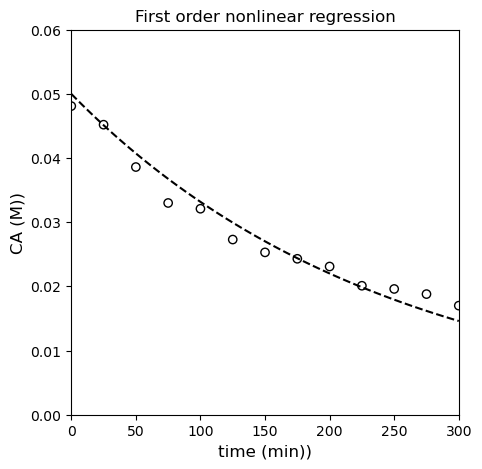

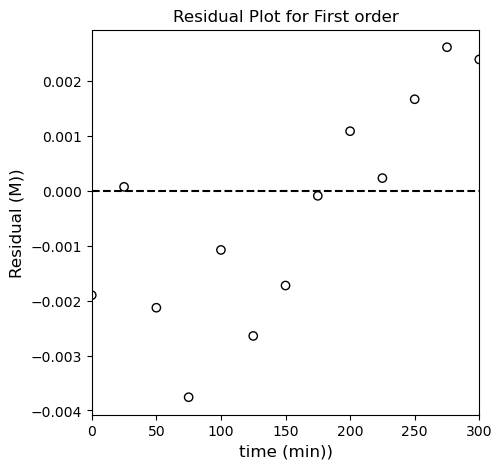

In [145]:
ans1 = opt.minimize_scalar(OBJONE)#, method = 'Brent', bracket = [0.01, 0.05])
SSE1 = ans1.fun
k1   = ans1.x

#Calculate result for best fit first order model
tsmooth   = np.linspace(0, max(tdata), 100)
CA0       = 0.05 #mol/L
CAPRED1   = CA0*np.exp(-k1*tdata)
CMOD1     = CA0*np.exp(-k1*tsmooth)
JAC1      = JACONE(k1)

Ndata     = len(tdata)
DOF       = Ndata - 1
MSE1      = SSE1/Ndata
RMSE1     = np.sqrt(MSE1)
MAE1      = 1/Ndata*np.sum(np.abs(CAdata - CAPRED1))
COV1      = SSE1/DOF*1/(JAC1.T@JAC1)
SEk1      = np.sqrt(COV1) 
tval      = stats.t.ppf(0.975, DOF)
CIk1      = tval*SEk1

CAbar     = np.mean(CAdata)
SST1      = np.sum((CAdata - CAbar)**2)
R21       = 1 - SSE1/SST1

print('\n', ans1, '\n')

labels = ['k', 'α', 'SSE', 'MSE', 'RMSE', 'MAE', 'R2']
values = [k1, 1, SSE1, MSE1, RMSE1, MAE1, R21]

for label, value in zip(labels, values):
    if label == 'k':
        print(f'{label:4s} = {value:0.2E} +/- {CIk1:0.2E}')
    else:
        print(f'{label:4s} = {value:0.2E}')

#Overlay best fit model with data
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.plot(tsmooth, CMOD1, color = 'black', linestyle = 'dashed')
plt.title('First order nonlinear regression')
plt.xlabel('time (min))', fontsize = 12)
plt.ylabel('CA (M))', fontsize = 12)
plt.xlim(0, max(tdata))
plt.ylim(0, 0.06)
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPRED1), marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.hlines(0, 0, max(tdata), color = 'black', linestyle = 'dashed')
plt.title('Residual Plot for First order')
plt.xlabel('time (min))', fontsize = 12)
plt.ylabel('Residual (M))', fontsize = 12)
plt.xlim(0, max(tdata))
plt.show()

Now we have some quantitative assessments of goodness of fit.  For real data, an $R^2$ of 0.96 or so is pretty good, so for the moment, we'll call this an acceptable fit.

### Second Order Nonlinear Regression

Now let's see how a second order model fits the data.  We'll go ahead and regress the best fit rate constant, plot the result, and calculate some basic statistical data about goodness of fit.

In [148]:
def OBJTWO(k):
    CA0      = 0.05 #mol/L
    tDATA    = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
    CADATA   = np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                    
    CASECOND = 1/(1/CA0 + k*tDATA)
    RESID    = CADATA - CASECOND
    SSE      = np.sum(RESID**2)
    print(f'k = {k:7.2E}, SSE = {SSE:7.2E}')
    return SSE

def JACTWO(k):
    CA0     = 0.05 #mol/L
    tDATA   = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
    CADATA  = np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                    
    JAC     = -tdata/(1/CA0 + k*tdata)**2
    return JAC

k = 0.00E+00, SSE = 7.16E-03
k = 1.00E+00, SSE = 4.64E-03
k = 2.62E+00, SSE = 7.06E-03
k = 1.62E+00, SSE = 5.96E-03
k = 6.18E-01, SSE = 3.17E-03
k = 3.82E-01, SSE = 1.76E-03
k = 2.36E-01, SSE = 6.33E-04
k = 1.46E-01, SSE = 5.44E-05
k = 9.02E-02, SSE = 1.67E-04
k = 1.36E-01, SSE = 2.55E-05
k = 1.28E-01, SSE = 1.43E-05
k = 1.13E-01, SSE = 2.54E-05
k = 1.24E-01, SSE = 1.30E-05
k = 1.24E-01, SSE = 1.30E-05
k = 1.24E-01, SSE = 1.30E-05
k = 1.24E-01, SSE = 1.30E-05
k = 1.24E-01, SSE = 1.30E-05
k = 1.24E-01, SSE = 1.30E-05
k = 1.24E-01, SSE = 1.30E-05
k = 1.24E-01, SSE = 1.30E-05

  message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 1.3014231460548605e-05
       x: 0.12389199401310891
     nit: 17
    nfev: 20 

k    = 1.24E-01 +/- 7.16E-03
α    = 2.00E+00
SSE  = 1.30E-05
MSE  = 1.00E-06
RMSE = 1.00E-03
MAE  = 8.29E-04
R2   = 9.89E-01


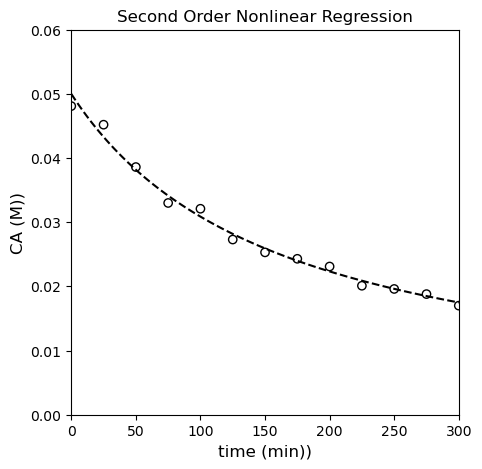

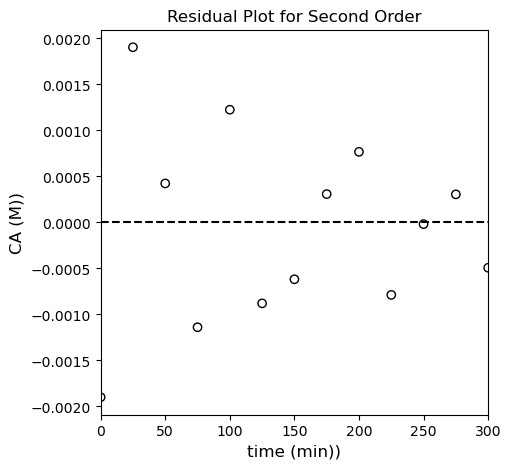

In [149]:
ans2 = opt.minimize_scalar(OBJTWO)#, method = 'Brent', bracket = [0.01, 0.05])
SSE2 = ans2.fun
k2   = ans2.x

#Calculate result for best fit first order model
tsmooth   = np.linspace(0, max(tdata), 100)
CA0       = 0.05 #mol/L
CAPRED2   = 1/(1/CA0 + k2*tdata)
CMOD2     = 1/(1/CA0 + k2*tsmooth)
JAC2      = JACTWO(k2)

Ndata     = len(tdata)
DOF       = Ndata - 1
MSE2      = SSE2/Ndata
RMSE2     = np.sqrt(MSE2)
MAE2      = 1/Ndata*np.sum(np.abs(CAdata - CAPRED2))
COV2      = SSE2/DOF*1/(JAC2.T@JAC2)
SEk2      = np.sqrt(COV2) 
tval      = stats.t.ppf(0.975, DOF)
CIk2      = tval*SEk2

CAbar     = np.mean(CAdata)
SST2      = np.sum((CAdata - CAbar)**2)
R22       = 1 - SSE2/SST2

print('\n', ans2, '\n')

labels = ['k', 'α', 'SSE', 'MSE', 'RMSE', 'MAE', 'R2']
values = [k2, 2, SSE2, MSE2, RMSE2, MAE2, R22]

for label, value in zip(labels, values):
    if label == 'k':
        print(f'{label:4s} = {value:0.2E} +/- {CIk2:0.2E}')
    else:
        print(f'{label:4s} = {value:0.2E}')

#Overlay best fit model with data
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.plot(tsmooth, CMOD2, color = 'black', linestyle = 'dashed')
plt.title('Second Order Nonlinear Regression')
plt.xlabel('time (min))', fontsize = 12)
plt.ylabel('CA (M))', fontsize = 12)
plt.xlim(0, max(tdata))
plt.ylim(0, 0.06)
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPRED2), marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.hlines(0, 0, max(tdata), color = 'black', linestyle = 'dashed')
plt.title('Residual Plot for Second Order')
plt.xlabel('time (min))', fontsize = 12)
plt.ylabel('CA (M))', fontsize = 12)
plt.xlim(0, max(tdata))
plt.show()

OK, by all metrics--visual, SSE, and $R^2$, the second order model improves on the first order model.  Is it the best?  It's hard to say for sure...let's try the third order model and see how that goes.

In [150]:
def OBJTHREE(k):
    CA0      = 0.05 #mol/L
    tDATA    = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
    CADATA   = np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                    
    CATHIRD  = np.sqrt(1/(1/CA0**2 + 2*k*tDATA))
    RESID    = CADATA - CATHIRD
    SSE      = np.sum(RESID**2)
    print(f'k = {k:7.2E}, SSE = {SSE:7.2E}')
    return SSE

def JACTHREE(k):
    CA0     = 0.05 #mol/L
    tDATA   = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]) #time in minutes
    CADATA  = np.array([0.0481, 0.0452, 0.0386, 0.0330, 0.0321, 0.0273, 0.0253, 0.0243, 0.0231, 0.0201, 0.0196, 0.0188, 0.0170])                    
    JAC     = (1/(1/CA0**2 + 2*k*tdata))**(-1/2) * -tdata/(1/CA0**2 + 2*k*tdata)**2
    return JAC

k = 0.00E+00, SSE = 7.16E-03
k = 1.00E+00, SSE = 1.60E-03
k = 2.62E+00, SSE = 1.59E-04
k = 2.06E+00, SSE = 3.75E-04
k = 5.24E+00, SSE = 1.67E-04
k = 3.62E+00, SSE = 4.63E-05
k = 4.24E+00, SSE = 6.64E-05
k = 3.75E+00, SSE = 4.66E-05
k = 3.67E+00, SSE = 4.62E-05
k = 3.67E+00, SSE = 4.62E-05
k = 3.67E+00, SSE = 4.62E-05
k = 3.67E+00, SSE = 4.62E-05
k = 3.67E+00, SSE = 4.62E-05
k = 3.67E+00, SSE = 4.62E-05
k = 3.67E+00, SSE = 4.62E-05

  message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 4.6162100913375796e-05
       x: 3.6669266287505446
     nit: 10
    nfev: 15 

k    = 3.67E+00 +/- 5.10E-01
α    = 3.00E+00
SSE  = 4.62E-05
MSE  = 3.55E-06
RMSE = 1.88E-03
MAE  = 1.52E-03
R2   = 9.63E-01


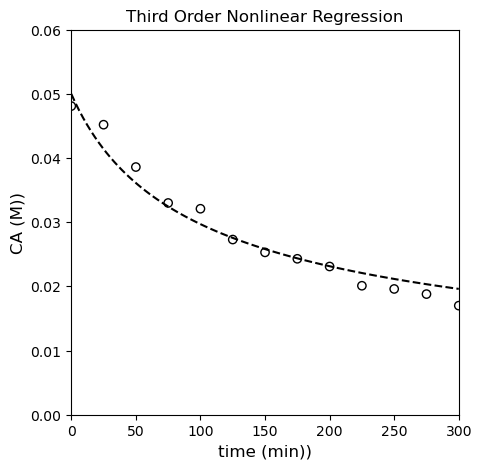

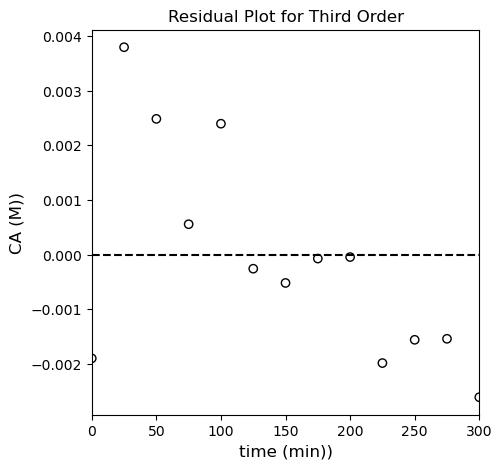

In [151]:
ans3 = opt.minimize_scalar(OBJTHREE)#, method = 'Brent', bracket = [0.01, 0.05])
SSE3 = ans3.fun
k3   = ans3.x

#Calculate result for best fit first order model
tsmooth   = np.linspace(0, max(tdata), 100)
CA0       = 0.05 #mol/L
CAPRED3   = np.sqrt(1/(1/CA0**2 + 2*k3*tdata))
CMOD3     = np.sqrt(1/(1/CA0**2 + 2*k3*tsmooth))
JAC3      = JACTHREE(k3)

Ndata     = len(tdata)
DOF       = Ndata - 1
MSE3      = SSE3/Ndata
RMSE3     = np.sqrt(MSE3)
MAE3      = 1/Ndata*np.sum(np.abs(CAdata - CAPRED3))
COV3      = SSE3/DOF*1/(JAC3.T@JAC3)
SEk3      = np.sqrt(COV3) 
tval      = stats.t.ppf(0.975, DOF)
CIk3      = tval*SEk3

CAbar     = np.mean(CAdata)
SST3      = np.sum((CAdata - CAbar)**2)
R23       = 1 - SSE3/SST3

print('\n', ans3, '\n')

labels = ['k', 'α', 'SSE', 'MSE', 'RMSE', 'MAE', 'R2']
values = [k3, 3, SSE3, MSE3, RMSE3, MAE3, R23]

for label, value in zip(labels, values):
    if label == 'k':
        print(f'{label:4s} = {value:0.2E} +/- {CIk3:0.2E}')
    else:
        print(f'{label:4s} = {value:0.2E}')

#Overlay best fit model with data
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.plot(tsmooth, CMOD3, color = 'black', linestyle = 'dashed')
plt.title('Third Order Nonlinear Regression')
plt.xlabel('time (min))', fontsize = 12)
plt.ylabel('CA (M))', fontsize = 12)
plt.xlim(0, max(tdata))
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
plt.ylim(0, 0.06)
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAPRED3), marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.hlines(0, 0, max(tdata), color = 'black', linestyle = 'dashed')
plt.title('Residual Plot for Third Order')
plt.xlabel('time (min))', fontsize = 12)
plt.ylabel('CA (M))', fontsize = 12)
plt.xlim(0, max(tdata))
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
#plt.ylim(0, 0.06)
plt.show()

Alright...looks like we've gone a little too far.  The third order model is slightly better than the first order model and slightly worse than the second order model.  Any of them probably do an OK job of fitting the data, but quantitatively, the second order model is probably just a bit better.  

As we discussed during Lecture 29, it can be really hard to tell whether or not a model is "correct" just by visual inspection.  All of the above, in isolation, seem to fit the data pretty well. We'll overlay all three where you can start to see that the second order model does the best.  Then, we'll look at linearized models if we can to see if we can see some deviation from linearity.

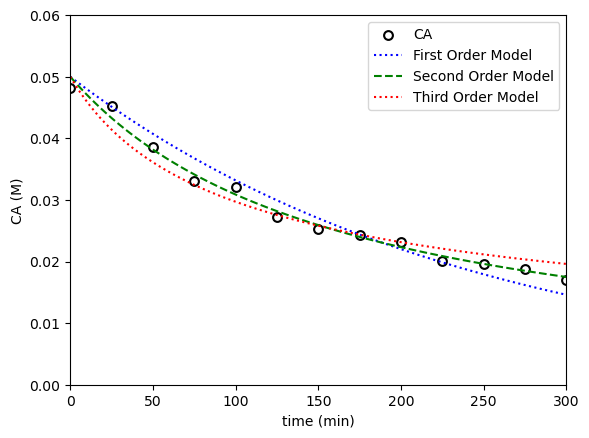

In [152]:
#Overlay best fit models with data
plt.scatter(tdata, CAdata, label = 'CA', color = 'white', edgecolor = 'black', linewidth = 1.5, s = 40)
plt.plot(tsmooth, CMOD1,  color = 'blue',  linewidth = 1.5, linestyle = 'dotted', label = 'First Order Model')
plt.plot(tsmooth, CMOD2, color = 'green', linewidth = 1.5, linestyle = 'dashed', label = 'Second Order Model')
plt.plot(tsmooth, CMOD3,  color = 'red',   linewidth = 1.5, linestyle = 'dotted', label = 'Third Order Model')
plt.xlabel('time (min)')
plt.ylabel('CA (M)')
plt.ylim(0, 0.06)
plt.xlim(0, max(tdata))
plt.legend()
plt.show()

### Linearization of Data

#### First Order Linearization

For the first order model, we have:

$$C_A = C_{A0}\exp(-k^\prime t)$$

This is a nonlinear function of, essentially kt; however, if we take the natural logarithm of both sides, we convert it to the following, which is much more useful:

$$\ln\left(C_A\right) = \ln\left(C_{A0}\right) - k^\prime t$$

If we plot $C_A$ against time, that should be linear if the first order model is correct.  The slope would be equal to -k, and the y-intercept would be ln(CA0).  

This is plotted in the cell below, where you observe linearity.

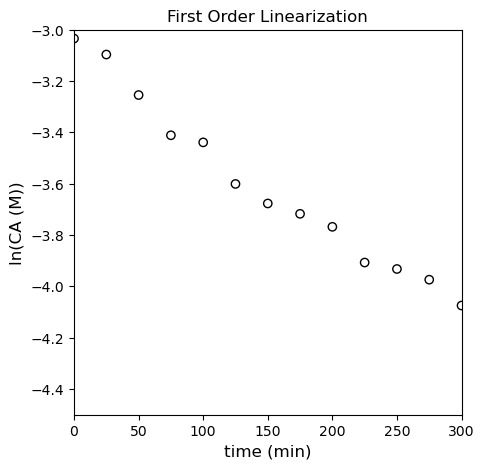

In [172]:
plt.figure(figsize = (5, 5))
plt.scatter(tdata, np.log(CAdata), marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.title('First Order Linearization')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('ln(CA (M))', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(-4.5, -3.0)
plt.show()

It looks pretty linear in isolation, but if we regress the line of best fit, we start to see systematic deviations; we'll also calculate all of the relevant meta statistical information.    I'll use the SSE and SST to calculate the R2 for this fit.  Note that SST is going to be based on $\ln(CA)$ and the mean value of $\ln(CA)$ for this linearized model.

m    = -3.43e-03 +/- 3.63e-04
b    = -3.09e+00 +/- 6.42e-02
SSE  = 0.03
SST  = 1.37
MSE  = 0.00
RMSE = 0.05
R2   = 0.98
CA0  = 4.54e-02 (but is between 4.26e-02 and 4.84e-02)
k    = 3.43e-03 +/- 3.63e-04


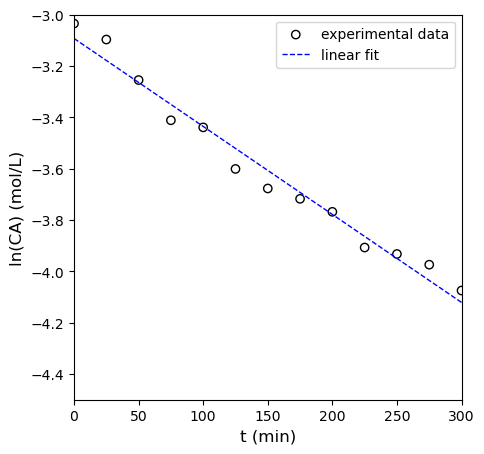

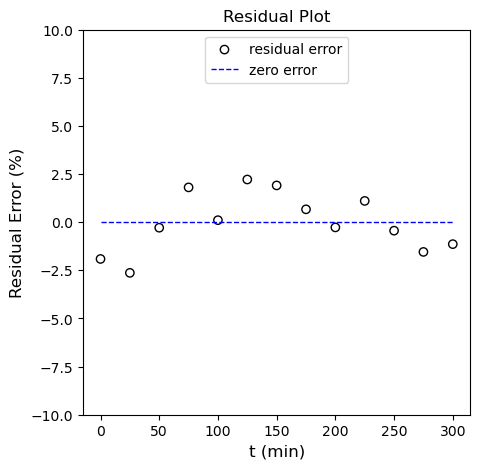

In [171]:
ydata = np.log(CAdata)
xdata = tdata
X     = np.vander(xdata, 2)
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = -m
CA0   = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'CA0', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, CA0, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2e} +/- {CIb:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'CA0':
        print(f'{label:4s} = {value:0.2e} (but is between {np.exp(b-CIb):0.2e} and {np.exp(b+CIb):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(-4.5, -3)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
# plt.xlim(-4.5, -2.5)
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

**Second Order Model**

For the second order model, we have:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

We should see linearity here if we plot $\frac{1}{C_A}$ vs $t$.  See below; this model clearly shows less deviation from linearity than the first order linearization.

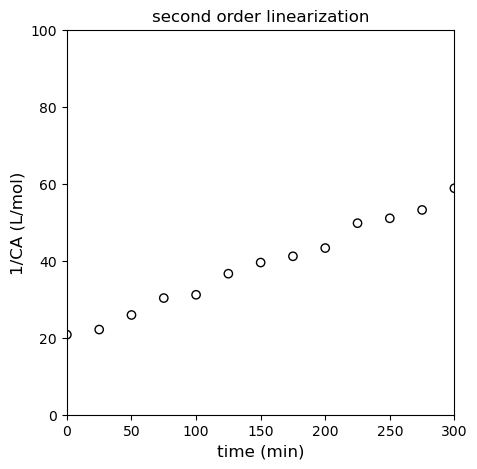

In [169]:
plt.figure(figsize = (5, 5))
plt.scatter(tdata, 1/CAdata, marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.title('second order linearization')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('1/CA (L/mol)', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(0, 100)
plt.show()

Below, I regress the coefficients for the linearized second order model using polyfit and overlay it with the "linearized" data set.

m    = 1.26e-01 +/- 7.70e-03
b    = 1.99e+01 +/- 1.36e+00
SSE  = 15.30
SST  = 1807.58
MSE  = 1.18
RMSE = 1.08
R2   = 0.99
CA0  = 5.02e-02 (but is between 4.70e-02 and 5.39e-02)
k    = 1.26e-01 +/- 7.70e-03


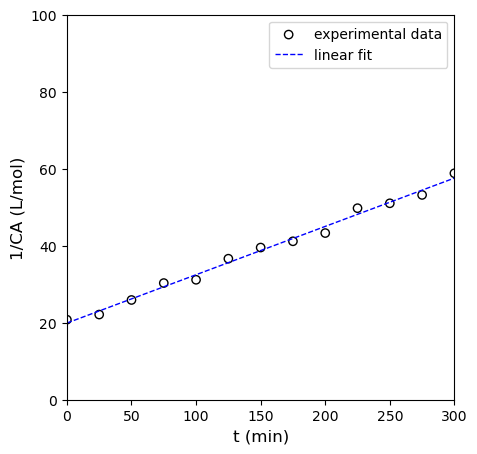

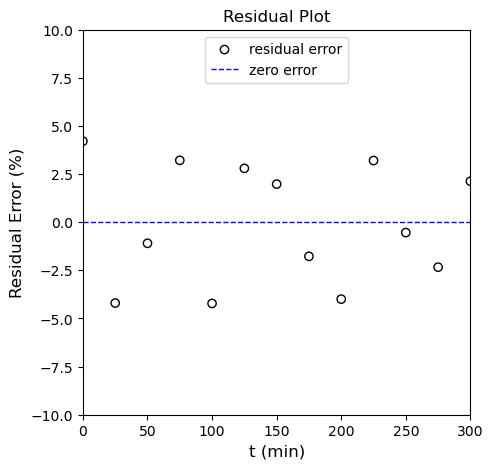

In [168]:
ydata = 1/CAdata
xdata = tdata

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m
CA0   = 1/b
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'CA0', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, CA0, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2e} +/- {CIb:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'CA0':
        print(f'{label:4s} = {value:0.2e} (but is between {1/(b+CIb):0.2e} and {1/(b-CIb):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('1/CA (L/mol)', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.xlim(0, 300)
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

I like the second order fit!  I can see scatter around the line of best fit instead of a systematic deviation like in the first order model. Let's check the third order linearization just to see if the second order model still looks better.

For the third order model, we have a slightly different linearization that is based on this form of the integrated model:

$$\frac{1}{{C_A}^2} = \frac{1}{{C_{A0}}^2} + 2k^\prime t$$

If we plot $\frac{1}{{C_A}^2}$ vs time, we should see linearity if the third order model is correct.

m    = 9.76e+00 +/- 1.17e+00
b    = 1.76e+02 +/- 2.06e+02
SSE  = 351988.52
SST  = 11195591.74
MSE  = 27076.04
RMSE = 164.55
R2   = 0.97
CA0  = 7.55e-02 (but is between 5.12e-02 and nan)
k    = 4.88e+00 +/- 5.84e-01


C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_8148\3728568886.py:38: RuntimeWarning: invalid value encountered in sqrt
  print(f'{label:4s} = {value:0.2e} (but is between {np.sqrt(1/(b+CIb)):0.2e} and {np.sqrt(1/(b-CIb)):0.2e})')


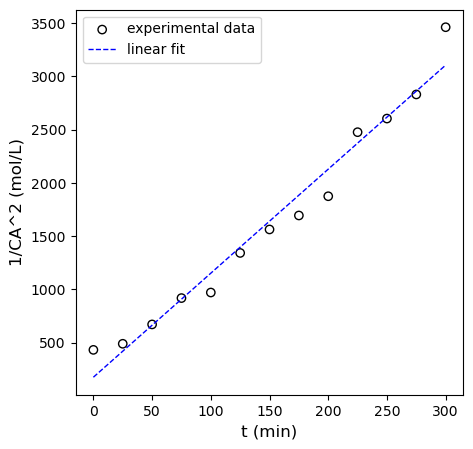

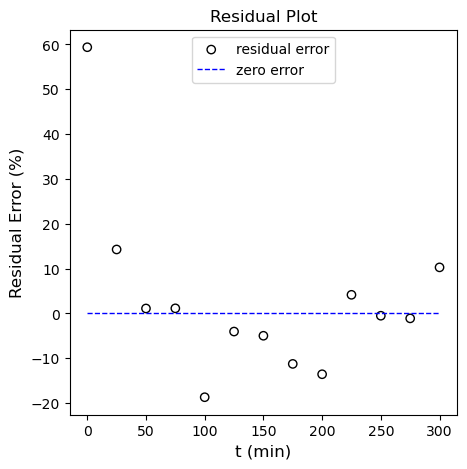

In [158]:
ydata = 1/CAdata**2
xdata = tdata

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m/2
CA0   = np.sqrt(1/b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'CA0', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, CA0, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2e} +/- {CIb:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm/2:0.2e}')
    elif label == 'CA0':
        print(f'{label:4s} = {value:0.2e} (but is between {np.sqrt(1/(b+CIb)):0.2e} and {np.sqrt(1/(b-CIb)):0.2e})')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('1/CA^2 (mol/L)', fontsize = 12)
# plt.xlim(-4.5, -2.5)
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
# plt.ylim(-11, -8)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
# plt.xlim(-4.5, -2.5)
# plt.xticks(np.arange(-4.5, -2.49, 0.5))
# plt.minorticks_on()
# plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

From everything we've done to this point, I am fairly confident in concluding that our reaction is second order in species A, so our rate law is:

$$r = k^\prime {C_A}^2$$

Remember, way back when we started this problem, that we defined $k^\prime$ as a lumped rate constant:

$$k^\prime = kC_{B0}$$

We know that the starting concentration of B in this system was 0.5M, so we can calculate the true rate constant as:

$$k = \frac{k^\prime}{C_{B0}}$$

And our final rate law is:

$$r = k{C_A}^2{C_B}$$

In [159]:
print(f'Our most precise estimate of the lumped rate constant is {k2:3.3f} L/mol/min')
print(f'The true rate constant is {k2/0.5:3.3f} L^2 mol^-2 min^-1')

Our most precise estimate of the lumped rate constant is 0.124 L/mol/min
The true rate constant is 0.248 L^2 mol^-2 min^-1


### If Time Allows, we can come back to this point

Considering all of the analysis, the second order model seems to fit the data best.  Since we know that the initial value of $C_{A0}$ is 0.05M, we can improve our precision on the rate constant estimation slightly by choosing to not regress the y-intercept.  We can do that by rearranging our linearization slightly:

Instead of working with:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + k^\prime t$$

And plotting $\frac{1}{C_A}$ vs. time, we will work with this form:

$$\frac{1}{C_A} - \frac{1}{C_{A0}} = k^\prime t$$

And we will plot $\frac{1}{C_A} - \frac{1}{C_{A0}}$ vs time. Alternatively, you could work with this form; either should give you a linear model with a zero y intercept:

$$\frac{(C_{A0} - C_A)}{C_{A0}C_A} = k^\prime t$$

I'll use the first form to construct the matrix form of our linear least squares problem:

$$\alpha_1t = \frac{1}{C_A} - \frac{1}{C_{A0}}$$

$$XA = Y$$

Where X is a vandermonde matrix created from tdata; however, we only keep the first order powers of time here (since there is no zero order coefficient in the model).  Y, in this case, is $\frac{1}{C_A} - \frac{1}{C_{A0}}$, and A is only a single coefficient, namely the slope of the line.  See below for implementation.  We can't use polyfit here, but if we know how to work with the vandermonde matrix, we have a lot of flexibility in regressions.  This is similar to what you can do with the LINEST function in Excel.

We'll leave the discussion of calculating standard error and confidence intervals for another day (or maybe explore sklearn utilities a bit).

m    = 1.25e-01 +/- 3.86e-03
SSE  = 15.32
SST  = 34175204.73
MSE  = 1.18
RMSE = 1.09
R2   = 1.00
k    = 1.25e-01 +/- 3.86e-03


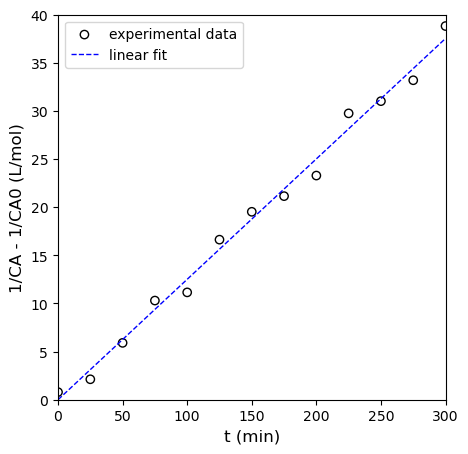

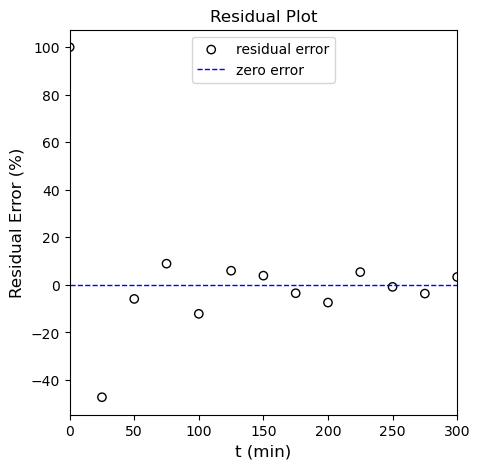

Our most precise estimate of the lumped rate constant is 0.125 inverse minutes
The true rate constant is 0.250 M^-1 min^-1


In [163]:
CA0   = 0.05 #M
X     = tdata.reshape(len(tdata),1) #I'm reshaping to make a 2D column instead of a 1D array; I have to do this to get dimensions correct for matrix product below
Y     = 1/CAdata - 1/CA0
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                #slope of best fit line
# b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
# SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
# CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m
# CA0   = np.sqrt(1/b)
labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE ,  SST , MSE , RMSE ,  R2, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X, Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('1/CA - 1/CA0 (L/mol)', fontsize = 12)
plt.xlim(0, 300)
plt.ylim(0, 40)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.xlim(0, 300)
# plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()
print(f'Our most precise estimate of the lumped rate constant is {A[0]:3.3f} inverse minutes')
print(f'The true rate constant is {A[0]/0.5:3.3f} M^-1 min^-1')